In [55]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
#import seaborn as sns
from matplotlib import rc
%matplotlib inline
#sns.set_style("whitegrid")

In [3]:
dfPatients = pd.read_csv(os.path.join("resources","base","joinedVect.csv"))

In [6]:
cols = dfPatients.columns
cols = [c for c in cols if 'Unn' not in c]
dfPatients = dfPatients[cols]
dfPatients.head()

,PATIENT,DAY,HOUR,EPISODE,ACTIVITY_ALONE,ACTIVITY_FAMILY,ACTIVITY_FRIENDS,ACTIVITY_SPORTS,ACTIVITY_STUDYING/WORKING,EMOTION_DISTRESSED,...,EMOTION_GUILTY,EMOTION_HAPPY,EMOTION_RELAXED,EMOTION_SAD,MEAL_+ 3 THIRD,MEAL_1 THIRD,MEAL_2 THIRD,MEAL_3 THIRD,MEAL_NOTHING,WEEK
0,P1,2015-11-01,1,2,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,44
1,P1,2015-11-01,2,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,44
2,P1,2015-11-01,3,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,44
3,P1,2015-11-02,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,45
4,P1,2015-11-02,2,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,45


In [43]:
dfPatientsVectExp = pd.get_dummies(dfPatients, columns=['EPISODE'])
filtCols =  [c for c in dfPatientsVectExp.columns if ('DAY' not in c and 'HOUR' not in c)]

res = dfPatientsVectExp[filtCols].groupby(by=['PATIENT','WEEK'])
resAll = res.agg(['sum'])
resAll.reset_index(level=[0,1], inplace=True)
resAll.sort(columns=['PATIENT','WEEK'],inplace=True)
finalCols = resAll.columns.get_level_values(0)
finalCols = [c for c in finalCols if 'PATIENT' not in c and 'WEEK' not in c]
print finalCols, len(finalCols)

print resAll[finalCols].values[:5,:]
data = pd.DataFrame(resAll[finalCols].values, columns=finalCols)
data.to_csv(os.path.join("resources","base","clusterData.csv"))

['ACTIVITY_ALONE', 'ACTIVITY_FAMILY', 'ACTIVITY_FRIENDS', 'ACTIVITY_SPORTS', 'ACTIVITY_STUDYING/WORKING', 'EMOTION_DISTRESSED', 'EMOTION_FUSTRATED', 'EMOTION_GUILTY', 'EMOTION_HAPPY', 'EMOTION_RELAXED', 'EMOTION_SAD', 'MEAL_+  3 THIRD', 'MEAL_1 THIRD', 'MEAL_2 THIRD', 'MEAL_3 THIRD', 'MEAL_NOTHING', 'EPISODE_0', 'EPISODE_1', 'EPISODE_2', 'EPISODE_3'] 20
[[ 3  4  9  3  2  2  2  3  2  7  5  2  4 10  4  1 17  2  2  0]
 [ 3  4  6  4  4  1  5  2  2  9  2  0  5  9  5  2 18  0  3  0]
 [ 5  3  3  4  6  1  1  5  5  4  5  0  8  6  4  3 16  0  5  0]
 [ 6  1  4  4  6  5  2  3  1  5  5  0  6  6  2  7 14  0  7  0]
 [ 0  1  0  1  1  0  0  0  0  2  1  0  0  1  1  1  2  0  1  0]]


/home/xrafael/Projects/hack/hackandhealth/venv/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [44]:
#### Clustering patients

In [76]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

stdData = scale(data)

In [79]:
df_sorted = []
best_clust = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init=15, init='k-means++',n_jobs=-1, random_state=13)
    cluster_labels = clusterer.fit_predict(stdData[:,:])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(stdData[:,:], cluster_labels,metric='euclidean')    
    best_clust.append([n_clusters, silhouette_avg, clusterer])

df_clustering = pd.DataFrame(best_clust, columns=('k','score','method'))
df_sorted = df_clustering.sort(columns='k',ascending=True)
   
print df_sorted[['k','score']].values, '\n'

[[  2.           0.23962927]
 [  3.           0.26724927]
 [  4.           0.15269565]
 [  5.           0.16884038]
 [  6.           0.15205586]
 [  7.           0.14369237]
 [  8.           0.13227276]
 [  9.           0.12981673]
 [ 10.           0.12678336]] 



/home/xrafael/Projects/hack/hackandhealth/venv/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


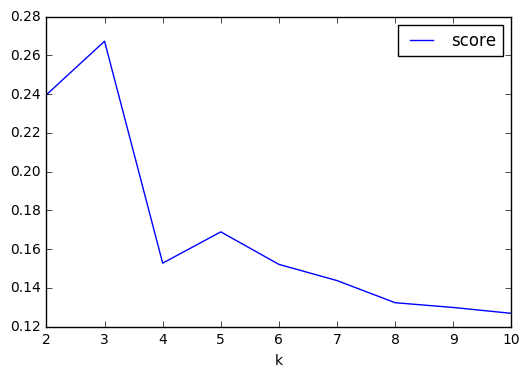

In [80]:
df_sorted[['k','score']].plot(x='k', y='score')
plt.show()

In [86]:
type_cols_index = 1
df_sorted.iloc[type_cols_index]['method']

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=15, n_jobs=-1, precompute_distances='auto',
    random_state=13, tol=0.0001, verbose=0)

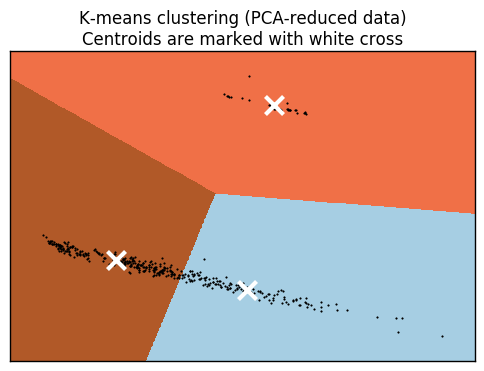

In [98]:
reduced_data = PCA(n_components=2).fit_transform(stdData)
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [99]:
pcacentroids

array([[ 2.41222982, -1.2964838 ],
       [ 3.20888479,  6.19851099],
       [-1.54592351, -0.0763565 ]])